# Train Model

In [1]:
import json
from utils import TrainWrapper
config = "/home/anubis/memdir/diploma/diff_unlearn/model/config.json"
save = "/home/anubis/memdir/diploma/diff_unlearn/model/model"

with open(config, "r") as fd:
    config = json.load(fd)

trainer = TrainWrapper(model_save=save, **config)
trainer.train()

EPOCH: 0


  0%|          | 0/938 [00:00<?, ?it/s]

# Unlearn Model

In [1]:
import os
import json
from utils import UnlearnWrapper

conf_path = "/home/anubis/memdir/diploma/diff_unlearn/model_unlearn"

for config in os.listdir(conf_path):
    config = os.path.join(conf_path, config)
    with open(config, "r") as fd:
        conf_dict = json.load(fd)
    
    unlearner = UnlearnWrapper(**conf_dict)
    unlearner()

  0%|          | 0/700 [00:00<?, ?it/s]

Step 0. Avarage of the last 50 loss values: 0.002752


# Sample

In [1]:
from diffusers import DDPMScheduler
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import torchvision
import torch

from unet import MNIST_Unet

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

DEVICE = "cuda"


In [2]:
model = MNIST_Unet()
model.load_state_dict(torch.load("model/model15.pt"))

<All keys matched successfully>

In [3]:
x = torch.randn(80, 1, 28, 28).to(DEVICE)
y = torch.tensor([[i]*8 for i in range(0, 10)]).flatten().to(DEVICE)
model.to(DEVICE)
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(x, t, y)  # Again, note that we pass in our labels y

    x = noise_scheduler.step(residual, t, x).prev_sample

0it [00:00, ?it/s]

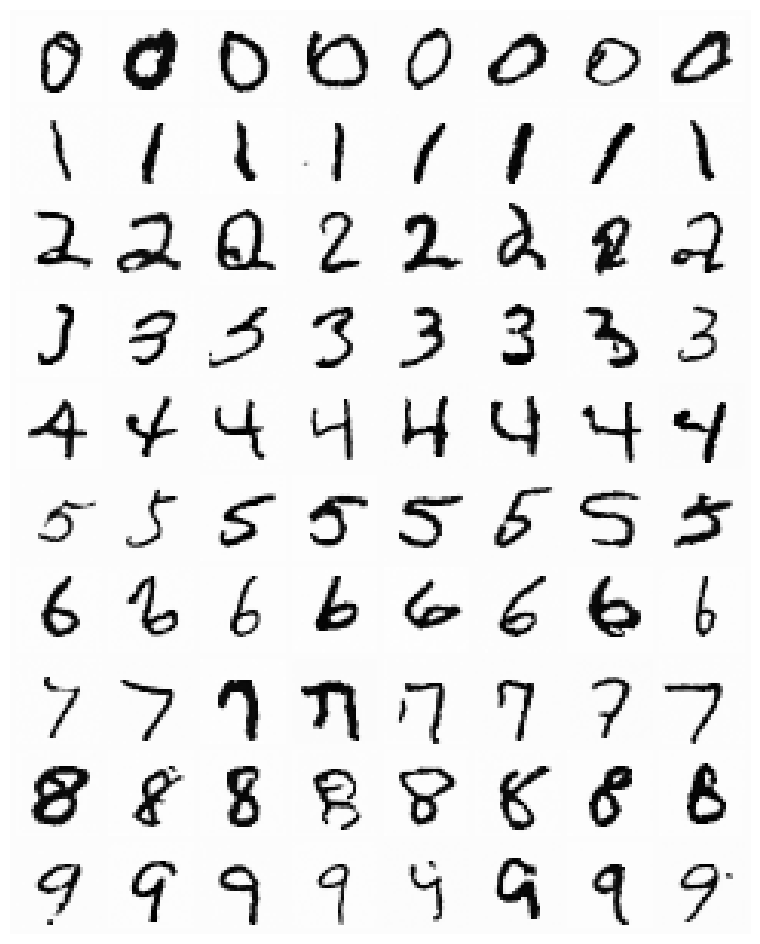

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.axis("off")
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')
plt.savefig("tests/sample.jpg")

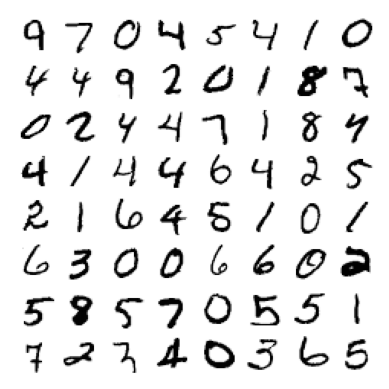

In [5]:
from utils.data import MakeDataLoader

loader_maker = MakeDataLoader(ds_name="mnist", batch_size=64)()